## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

## Read Train/Test Files

In [2]:
train_df = pd.read_parquet('../data/train_df.parquet')
test_df = pd.read_parquet('../data/test_df.parquet')
customer_profiles_table = pd.read_csv('../data/customer_profiles_table_new.csv')

In [3]:
train_df.dtypes

transaction_id              int64
tx_datetime        datetime64[ns]
customer_id                 int64
tx_amount                 float64
tx_time_seconds             int64
tx_fraud                    int64
dtype: object

In [4]:
customer_profiles_table.dtypes

customer_id        int64
x_customer_id    float64
y_customer_id    float64
dtype: object

## Feature Engineering

Variáveis criadas:

- **tx_hour**: Datetime em horas
- **tx_weekday**: Dia da semana baseado no datetime
- **tx_period_day**: Periodo do dia, se é manhã, tarde, noite ou madrugada
- **time_since_last_tx**: Tempo desde a última transação do cliente
- **nb_tx_last_1/7/30**: Contagem do número de transações na janela de tempo
- **avg_amount_last_1/7/30**: Média do valor das transações na janela de tempo
- **std_amount_last_1/7/30**: Desvio padrão do valor das transações na janela de tempo
- **tx_amount_median_ratio**: Mede a relação entre o valor da transação atual e a mediana dos valores das transações do mesmo cliente, ajudando a identificar desvios no padrão de gastos.
- **tx_amount_variation**: Variação percentual dos valores das transações consecutivas de um mesmo cliente, indicando possíveis mudanças abruptas nos gastos.
- **nb_tx_hour**: Número de transações realizadas por um cliente dentro de uma mesma hora, auxiliando na detecção de comportamentos incomuns, como um grande volume de transações em pouco tempo.
- **tx_amount_hour_mean**: Média dos valores das transações de um cliente em uma determinada hora, permitindo identificar se a transação atual está dentro do padrão usual de gastos do usuário.
- **mean_time_between_txs**: Tempo médio entre transações por cliente
- **std_time_between_txs**: Desvio padrão do tempo entre transações
- **tx_day**: Datetime em dias
- **tx_month**: Datetime em mês
- **mean_amount**: Média das transações
- **std_amount**: Desvio padrão das transações
- **distance_from_customer**: Distância entre a localização do cliente e a média das transações
- **is_single_tx_customer**: Clientes que realizou apenas uma única transação no histórico de dados. 
- **tx_amount_to_mean_ration**: Relação entre o valor da transação e a média da transação do cliente
- **repeated_tx**: Se há transações repetidas
- **outlier_tx**: Número de transações atípicas do cliente
- **unusual_hour**: Transações em horários incomum (antes das 6 e depois das 22)
- **frequent_tx**: Se há muitas transações em um curto período de tempo
- **high_value_tx**: Transações muito maiores que a média do cliente
- **amount_zscore_7d**: Mede o quão distante o valor da transação atual está da média dos últimos 7 dias
- **amount_zscore_30d**: Mede o quão distante o valor da transação atual está da média dos últimos 30 dias

In [5]:
def feature_engineering(df):
    df["tx_hour"] = df["tx_datetime"].dt.hour
    df["tx_weekday"] = df["tx_datetime"].dt.weekday

    # categoria por horario do dia
    df["tx_period_day"] = pd.cut(
        df["tx_hour"],
        bins=[0, 6, 12, 18, 24],
        labels=["madrugada", "manhã", "tarde", "noite"],
        right=False,
    )
    
    # Ordenar os dados por cliente e data para cálculo de diferenças de tempo
    df = df.sort_values(by=["customer_id", "tx_datetime"])

    # Criar feature de tempo desde a última transação do cliente
    df["time_since_last_tx"] = df.groupby("customer_id")["tx_datetime"].diff().dt.total_seconds()
    
    window_sizes = [1, 7, 30]

    for window in window_sizes:
        col_name = f"tx_in_window_{window}d"

        df[col_name] = df.groupby("customer_id")["tx_datetime"].diff().dt.days.fillna(0).lt(window).astype(int)

        df[f"nb_tx_last_{window}d"] = df.groupby("customer_id")[col_name].cumsum()

        df[f"avg_amount_last_{window}d"] = (
            df.groupby("customer_id")["tx_amount"]
            .transform(lambda x: x.rolling(window=min(len(x), window), min_periods=1).mean())
        )

        df[f"std_amount_last_{window}d"] = (
            df.groupby("customer_id")["tx_amount"]
            .transform(lambda x: x.rolling(window=min(len(x), window), min_periods=1).std())
        )

        df.drop(columns=[col_name], inplace=True)
        
    df = df.merge(customer_profiles_table, on="customer_id", how="left")

    df["tx_amount_median_ratio"] = df["tx_amount"] / df.groupby("customer_id")["tx_amount"].transform("median")
    df["tx_amount_variation"] = df.groupby("customer_id")["tx_amount"].transform(lambda x: x.pct_change().fillna(0))
    df["nb_tx_hour"] = df.groupby(["customer_id", "tx_hour"])["tx_amount"].transform("count")
    df["tx_amount_hour_mean"] = df.groupby(["customer_id", "tx_hour"])["tx_amount"].transform("mean")

    # Tempo médio entre transações por cliente
    df["mean_time_between_txs"] = df.groupby("customer_id")["time_since_last_tx"].transform("mean")

    # Desvio padrão do tempo entre transações
    df["std_time_between_txs"] = df.groupby("customer_id")["time_since_last_tx"].transform("std")

    # Dia e mes
    df["tx_day"] = df["tx_datetime"].dt.day
    df["tx_month"] = df["tx_datetime"].dt.month
    
    
    df["mean_amount"] = df.groupby("customer_id")["tx_amount"].transform("mean")
    df["std_amount"] = df.groupby("customer_id")["tx_amount"].transform("std")

    df["distance_from_customer"] = np.sqrt(
        (df["x_customer_id"] - df["x_customer_id"].mean())**2 +
        (df["y_customer_id"] - df["y_customer_id"].mean())**2
    )
    
    df["is_single_tx_customer"] = df.groupby("customer_id")["transaction_id"].transform("count") == 1

    df["tx_amount_to_mean_ration"] = df["tx_amount"] / df["mean_amount"]

    df["repeated_tx"] = df.duplicated(subset=["customer_id", "tx_amount"], keep=False)

    df["outlier_tx"] = np.abs(df["tx_amount"] - df["mean_amount"]) > (2 * df["std_amount"])

    df["unusual_hour"] = (df["tx_hour"] < 6) | (df["tx_hour"] > 22)

    df["frequent_tx"] = df["time_since_last_tx"] < 60

    df["high_value_tx"] = df["tx_amount"] > (3 * df["mean_amount"])
        
    df["std_amount_last_7d"].replace(0, 1e-6, inplace=True)
    df["std_amount_last_30d"].replace(0, 1e-6, inplace=True)

    df["amount_zscore_7d"] = (df["tx_amount"] - df["avg_amount_last_7d"]) / df["std_amount_last_7d"]
    df["amount_zscore_30d"] = (df["tx_amount"] - df["avg_amount_last_30d"]) / df["std_amount_last_30d"]
        
    return df

In [6]:
train_df = feature_engineering(train_df)

In [7]:
train_df.dtypes

transaction_id                       int64
tx_datetime                 datetime64[ns]
customer_id                          int64
tx_amount                          float64
tx_time_seconds                      int64
tx_fraud                             int64
tx_hour                              int64
tx_weekday                           int64
tx_period_day                     category
time_since_last_tx                 float64
nb_tx_last_1d                        int32
avg_amount_last_1d                 float64
std_amount_last_1d                 float64
nb_tx_last_7d                        int32
avg_amount_last_7d                 float64
std_amount_last_7d                 float64
nb_tx_last_30d                       int32
avg_amount_last_30d                float64
std_amount_last_30d                float64
x_customer_id                      float64
y_customer_id                      float64
tx_amount_median_ratio             float64
tx_amount_variation                float64
nb_tx_hour 

In [8]:
int32_cols = train_df.select_dtypes(include=['int32']).columns
train_df[int32_cols] = train_df[int32_cols].astype(np.int64)

# Tratando dados nulos

In [9]:
train_df.isna().sum()

transaction_id                    0
tx_datetime                       0
customer_id                       0
tx_amount                         0
tx_time_seconds                   0
tx_fraud                          0
tx_hour                           0
tx_weekday                        0
tx_period_day                     0
time_since_last_tx             4987
nb_tx_last_1d                     0
avg_amount_last_1d                0
std_amount_last_1d          1403324
nb_tx_last_7d                     0
avg_amount_last_7d                0
std_amount_last_7d             4987
nb_tx_last_30d                    0
avg_amount_last_30d               0
std_amount_last_30d            4987
x_customer_id                     0
y_customer_id                     0
tx_amount_median_ratio            0
tx_amount_variation               0
nb_tx_hour                        0
tx_amount_hour_mean               0
mean_time_between_txs            15
std_time_between_txs             33
tx_day                      

In [10]:
# Substituir NaN por um valor muito alto, indicando que nõa houve transações anteriores
train_df["time_since_last_tx"] = train_df["time_since_last_tx"].fillna(train_df["time_since_last_tx"].max())

# Se o cliente teve apenas uma transação na janela de tempo, o desvio padrão não será calculado. Substituir por 0
train_df['std_amount_last_1d'] = train_df["std_amount_last_1d"].fillna(0)
train_df['std_amount'] = train_df["std_amount"].fillna(0)
train_df["std_amount_last_7d"] = train_df["std_amount_last_7d"].fillna(0)
train_df["std_amount_last_30d"] = train_df["std_amount_last_30d"].fillna(0)

train_df['amount_zscore_30d'] = train_df['amount_zscore_30d'].fillna(0)
train_df['amount_zscore_7d'] = train_df['amount_zscore_7d'].fillna(0)

# Tratar valores nulos para clientes com apenas uma transação
mean_time_global = train_df["mean_time_between_txs"].mean()
std_time_global = train_df["std_time_between_txs"].mean()

train_df["mean_time_between_txs"].fillna(mean_time_global, inplace=True)
train_df["std_time_between_txs"].fillna(std_time_global, inplace=True)

train_df["tx_amount_variation"] = train_df["tx_amount_variation"].replace([np.inf, -np.inf], np.nan)
train_df["tx_amount_variation"].fillna(0, inplace=True)

## EDA

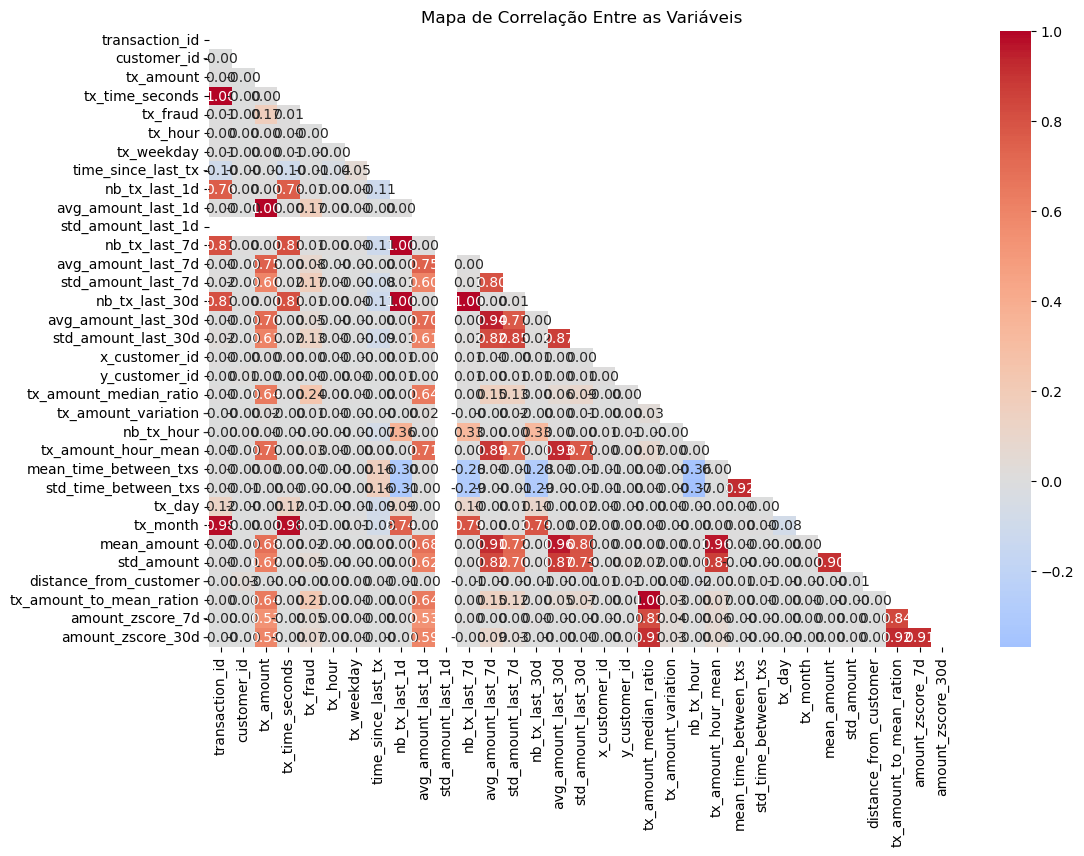

In [11]:
num_attributes = train_df.select_dtypes(include = ['int64', 'float64'])

corr_matrix = num_attributes.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mapa de Correlação Entre as Variáveis")
plt.show()

- Há diversas variáveis com alta correlação entre si. Vamos definir qual utilizar. Além de dropar a std_amount_last_1d, que é nula.

- tx_amount tem forte correlação com várias outras variáveis que ajudariam a detectar as fraudes baseadas no contexto histórico, porém, utilizamos a tx_amount como métrica para definir redução de custos, ou seja, é muito boa para explicabilidade dos resultados.

- avg_amount_last_1d também será removida pela forte correlação com as outras variáveis.

- Como temos a zscore, vamos excluir avg e std

- Na dúvida entre zscore_7d e zscore_30d, será necessário avaliar com um pouco mais de cuidado.

### Analisando zscore

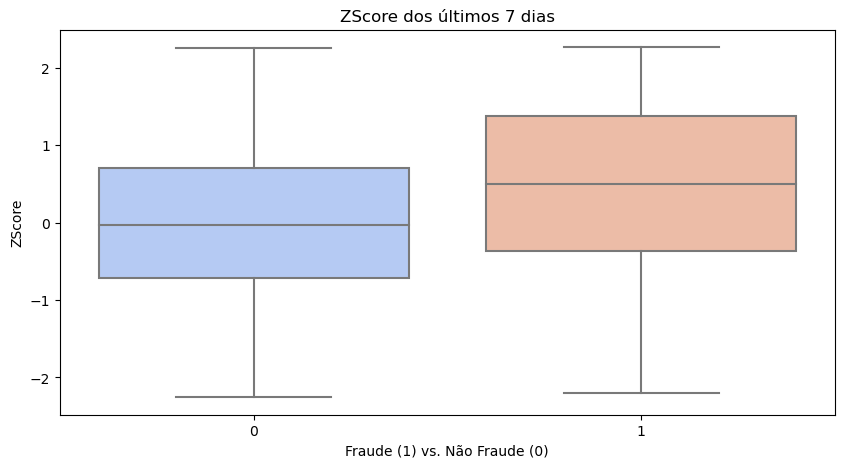

In [12]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="tx_fraud", y="amount_zscore_7d", showfliers=False, palette="coolwarm")
plt.title("ZScore dos últimos 7 dias")
plt.xlabel("Fraude (1) vs. Não Fraude (0)")
plt.ylabel("ZScore")
plt.show()

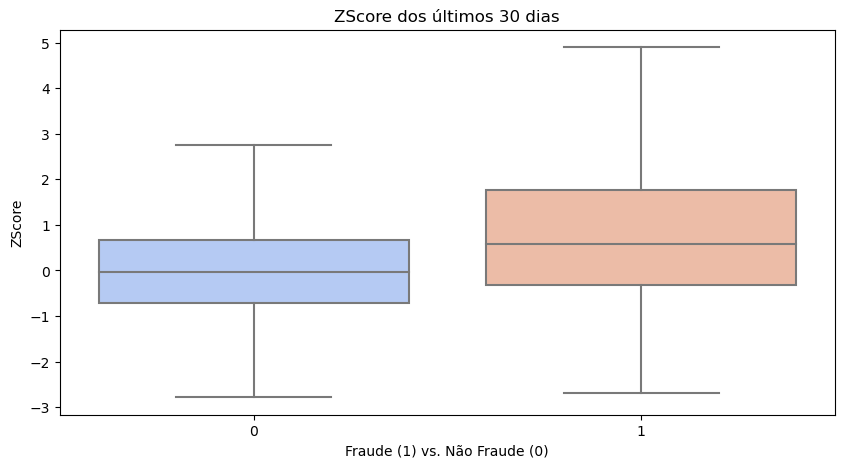

In [13]:
# Analisar tempo entre transações normais vs fraudes
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="tx_fraud", y="amount_zscore_30d", showfliers=False, palette="coolwarm")
plt.title("ZScore dos últimos 30 dias")
plt.xlabel("Fraude (1) vs. Não Fraude (0)")
plt.ylabel("ZScore")
plt.show()

In [14]:
train_df.groupby("tx_fraud")[["amount_zscore_7d", "amount_zscore_30d"]].mean()

,amount_zscore_7d,amount_zscore_30d
tx_fraud,,
0,-0.003806,-0.005774
1,0.476117,0.798505


amount_zscore_30d tem uma média muito maior para casos de fraude, ou seja, separa melhor fraudes de não fraudes. Vamos manter a 30d.

In [15]:
train_df = train_df.drop( ['amount_zscore_7d'], axis=1)

## Definindo quais colunas serão utilizadas

In [16]:
# from boruta import BorutaPy

# freq_encoding = train_df["tx_period_day"].value_counts(normalize=True).to_dict()

# train_df["tx_period_day_fe"] = train_df["tx_period_day"].map(freq_encoding)

# X = train_df.drop(columns=['tx_fraud', 'tx_period_day', 'tx_datetime'])
# y = train_df['tx_fraud']

# rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5, random_state=42)

# boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42)

# # Ajustar ao dataset
# boruta.fit(X.values, y.values)

# # Selecionar features aprovadas pelo Boruta
# selected_features = X.columns[boruta.support_]

# print(f"Features selecionadas: {selected_features}")

In [17]:
cols_boruta = ['tx_amount', 'tx_time_seconds',
       'time_since_last_tx', 'nb_tx_last_1d', 'avg_amount_last_1d',
       'nb_tx_last_7d', 'avg_amount_last_7d', 'std_amount_last_7d',
       'nb_tx_last_30d', 'avg_amount_last_30d', 'std_amount_last_30d',
       'x_customer_id', 'mean_amount', 'std_amount',
       'tx_amount_to_mean_ration', 'outlier_tx',
       'high_value_tx', 'amount_zscore_7d', 'amount_zscore_30d']

# Muitas colunas fortemente correlacionada, precisarei manualmente selecionar as colunas!

In [18]:
features = ['amount_zscore_30d','tx_time_seconds','time_since_last_tx','distance_from_customer','tx_hour',
            'tx_weekday','repeated_tx','unusual_hour','frequent_tx','tx_fraud','tx_amount','tx_period_day']

train_df = train_df[features]

## Tratando dados categoricos

In [19]:
freq_encoding = train_df["tx_period_day"].value_counts(normalize=True).to_dict()

train_df["tx_period_day_fe"] = train_df["tx_period_day"].map(freq_encoding)

train_df.drop(columns=["tx_period_day"], inplace=True)

In [20]:
train_df.columns

Index(['amount_zscore_30d', 'tx_time_seconds', 'time_since_last_tx',
       'distance_from_customer', 'tx_hour', 'tx_weekday', 'repeated_tx',
       'unusual_hour', 'frequent_tx', 'tx_fraud', 'tx_amount',
       'tx_period_day_fe'],
      dtype='object')

## Treinando Modelo

### tratando dados de teste

In [21]:
test_df = feature_engineering(test_df)

freq_encoding = test_df["tx_period_day"].value_counts(normalize=True).to_dict()
test_df = test_df[features]

test_df["tx_period_day_fe"] = test_df["tx_period_day"].map(freq_encoding)

test_df = test_df.drop(['tx_period_day'], axis=1)

test_df['amount_zscore_30d'] = test_df['amount_zscore_30d'].fillna(0)
test_df["time_since_last_tx"] = test_df["time_since_last_tx"].fillna(test_df["time_since_last_tx"].max())

In [22]:
test_df.isna().sum()

amount_zscore_30d         0
tx_time_seconds           0
time_since_last_tx        0
distance_from_customer    0
tx_hour                   0
tx_weekday                0
repeated_tx               0
unusual_hour              0
frequent_tx               0
tx_fraud                  0
tx_amount                 0
tx_period_day_fe          0
dtype: int64

### Separando em treino e teste

In [23]:
train_df.columns

Index(['amount_zscore_30d', 'tx_time_seconds', 'time_since_last_tx',
       'distance_from_customer', 'tx_hour', 'tx_weekday', 'repeated_tx',
       'unusual_hour', 'frequent_tx', 'tx_fraud', 'tx_amount',
       'tx_period_day_fe'],
      dtype='object')

In [24]:
test_df.columns

Index(['amount_zscore_30d', 'tx_time_seconds', 'time_since_last_tx',
       'distance_from_customer', 'tx_hour', 'tx_weekday', 'repeated_tx',
       'unusual_hour', 'frequent_tx', 'tx_fraud', 'tx_amount',
       'tx_period_day_fe'],
      dtype='object')

In [25]:
X_train, y_train = train_df.drop(columns=["tx_fraud"]), train_df["tx_fraud"]
X_test, y_test = test_df.drop(columns=["tx_fraud"]), test_df["tx_fraud"]

### Modelos

In [26]:
rf_model_desbalanceada = RandomForestClassifier(
                    n_estimators=200,       # Número de árvores
                    max_depth=7,            # Controle de profundidade (complexidade)
                    min_samples_split=15,   # Evita splits com poucos exemplos
                    min_samples_leaf=7,     # Evita folhas muito pequenas
                    max_features='sqrt',    # Aumenta diversidade das árvores
                    bootstrap=True,         # Mantém aleatoriedade na amostragem
                    random_state=42,
                    n_jobs=-1               # Usa todos os processadores disponíveis
                )
rf_model_desbalanceada.fit(X_train, y_train)

rf_model = RandomForestClassifier(
                    n_estimators=200,
                    max_depth=7,
                    min_samples_split=15,
                    min_samples_leaf=7,
                    max_features='sqrt',
                    class_weight='balanced_subsample',
                    bootstrap=True,
                    random_state=42,
                    n_jobs=-1
                )
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(
                    n_estimators=200,         # Número de árvores
                    max_depth=4,              # Controle de profundidade (complexidade)
                    learning_rate=0.05,       # Aprendizado mais suave
                    colsample_bytree=0.8,     # Mantém diversidade das features
                    scale_pos_weight=3,       # Balanceamento da classe fraudulenta
                    min_child_weight=10,      # Evita splits fracos
                    gamma=5,                  # Penaliza splits irrelevantes
                    subsample=0.7,            # Evita overfitting ao limitar amostras por árvore
                    reg_lambda=10,            # Regularização L2 para reduzir overfit
                    random_state=42,
                    enable_categorical=True
                )
xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMClassifier(
                    n_estimators=200,
                    max_depth=4,
                    learning_rate=0.05,
                    colsample_bytree=0.8,
                    min_child_weight=5,  # Reduzindo de 10 para permitir mais divisões
                    reg_lambda=10,
                    subsample=0.7,
                    force_row_wise=True,
                    min_split_gain=0.01,  # Evita splits sem ganho real
                    scale_pos_weight=2.0,  # Ajuste para melhorar precisão
                    random_state=42,
                    verbose=-1
                )
lgb_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8, force_row_wise=True, learning_rate=0.05,
               max_depth=4, min_child_weight=5, min_split_gain=0.01,
               n_estimators=200, random_state=42, reg_lambda=10,
               scale_pos_weight=2.0, subsample=0.7, verbose=-1)

## Avaliação

In [27]:
def avaliar_multiplos_modelos(models, X_train, y_train, X_test, y_test, threshold=0.5):
    """
    Avalia múltiplos modelos de Machine Learning comparando desempenho em treino e teste.

    Parâmetros:
    - models: dicionário de modelos treinados { "Nome do Modelo": modelo_treinado }
    - X_train: features de treino
    - y_train: labels de treino
    - X_test: features de teste
    - y_test: labels de teste
    - threshold: valor limite para converter probabilidades em classes (default = 0.5)

    Retorna:
    - DataFrame com métricas de treino e teste para cada modelo
    - Exibe matrizes de confusão para cada modelo
    """

    results = []

    for name, model in models.items():
        print(f"\n=== Avaliação do Modelo: {name} ===")

        # Predições em treino e teste
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]

        y_train_pred = (y_train_proba >= threshold).astype(int)
        y_test_pred = (y_test_proba >= threshold).astype(int)

        # Cálculo das métricas
        train_auc = roc_auc_score(y_train, y_train_proba)
        train_precision = precision_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred)

        test_auc = roc_auc_score(y_test, y_test_proba)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        # Adiciona resultados ao DataFrame
        results.append([name, train_auc, test_auc, train_precision, test_precision, train_recall, test_recall, train_f1, test_f1])

    # Criar um DataFrame com os resultados
    df_results = pd.DataFrame(results, columns=[
        "Modelo", "AUC-ROC (Treino)", "AUC-ROC (Teste)", 
        "Precision (Treino)", "Precision (Teste)", 
        "Recall (Treino)", "Recall (Teste)", 
        "F1-Score (Treino)", "F1-Score (Teste)"
    ])
    
    return df_results

In [28]:
models = {
    "XGBoost": xgb_model,
    "LightGBM": lgb_model,
    "Random Forest": rf_model
}

df_resultados = avaliar_multiplos_modelos(models, X_train, y_train, X_test, y_test, threshold=0.4)


=== Avaliação do Modelo: XGBoost ===

=== Avaliação do Modelo: LightGBM ===

=== Avaliação do Modelo: Random Forest ===


In [29]:
df_resultados

,Modelo,AUC-ROC (Treino),AUC-ROC (Teste),Precision (Treino),Precision (Teste),Recall (Treino),Recall (Teste),F1-Score (Treino),F1-Score (Teste)
0,XGBoost,0.740267,0.671741,0.506360,0.506267,0.248547,0.230794,0.333430,0.317052
1,LightGBM,0.741024,0.677155,0.538896,0.534143,0.239702,0.223492,0.331813,0.315130
2,Random Forest,0.726352,0.653490,0.009381,0.009131,0.964357,0.973016,0.018582,0.018092


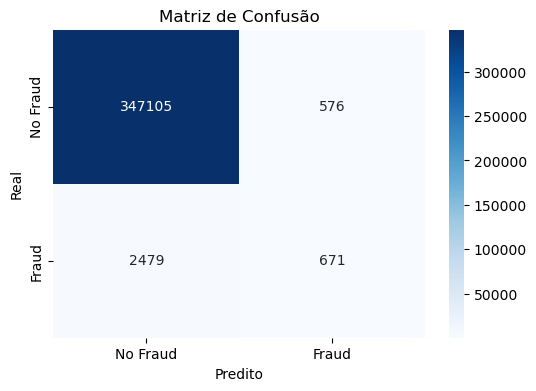

In [30]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

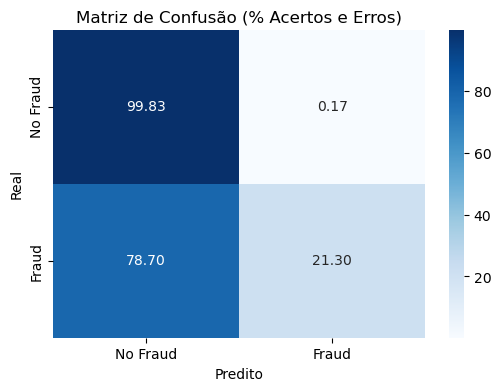

In [31]:
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão (% Acertos e Erros)")
plt.show()

Nosso modelo tem um excelente desempenho em evitar falsos positivos, ou seja, quase nenhuma transação legítima está sendo considerada como fraude (0.17%). Isso reduz o impacto para clientes legítmos. Por outro lado, o modelo tem uma taxa alta de falsos negativos (78.70%), ou seja, ele não detecta a maioria das fraudes. Apenas 21.30% das transações fraudulentas foram identificadas corretamente.

In [32]:
def gerar_classificacao(models, X_test, y_test, threshold=0.4):
    """
    Aplica os modelos treinados no conjunto de teste e retorna um DataFrame com a classificação correta.

    Parâmetros:
    - models: dicionário { "Nome do Modelo": modelo_instanciado }
    - X_test: features de teste
    - y_test: labels de teste
    - threshold: valor para converter probabilidades em classes (default=0.4)

    Retorna:
    - DataFrame com as previsões e a classificação correta (TP, FP, FN, TN).
    """

    results_df = X_test.copy()
    results_df["Real"] = y_test.values

    for name, model in models.items():
        # Fazer predição do modelo
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Criar colunas de predição para cada modelo
        results_df[f"Predito_{name}"] = y_pred

        # Definir classificações (TP, FP, FN, TN)
        conditions = [
            (results_df["Real"] == 0) & (results_df[f"Predito_{name}"] == 0),  # TN
            (results_df["Real"] == 0) & (results_df[f"Predito_{name}"] == 1),  # FP
            (results_df["Real"] == 1) & (results_df[f"Predito_{name}"] == 0),  # FN
            (results_df["Real"] == 1) & (results_df[f"Predito_{name}"] == 1)   # TP
        ]
        choices = ["TN", "FP", "FN", "TP"]

        # Adicionar coluna de classificação específica para cada modelo
        results_df[f"Classificação_{name}"] = np.select(conditions, choices, default="Erro")

    return results_df

In [33]:
def avaliar_perdas(models, results_df, test_df):
    """
    Calcula o impacto financeiro de fraudes detectadas e não detectadas para cada modelo.

    Parâmetros:
    - models: dicionário { "Nome do Modelo": modelo_instanciado }
    - results_df: DataFrame contendo as previsões e classificações de cada modelo.
    - test_df: DataFrame original de teste contendo 'tx_amount' e 'tx_fraud'.

    Retorna:
    - DataFrame consolidado com os valores financeiros perdidos por modelo.
    """

    # Total de transações e total de fraudes reais no conjunto de teste
    total_amount = test_df['tx_amount'].sum()
    total_amount_fraud = test_df[test_df['tx_fraud'] == 1]['tx_amount'].sum()

    # Baseline (quanto perderíamos sem modelo nenhum)
    baseline = float(total_amount_fraud)
    ciclo_01 = float(286230.30)
    results = []

    for name in models.keys():
        # Cálculo dos valores perdidos por classificação
        tp_tx_amount = results_df[results_df[f"Classificação_{name}"] == "TP"]['tx_amount'].sum()
        fn_tx_amount = results_df[results_df[f"Classificação_{name}"] == "FN"]['tx_amount'].sum()
        fp_tx_amount = results_df[results_df[f"Classificação_{name}"] == "FP"]['tx_amount'].sum()
        tn_tx_amount = results_df[results_df[f"Classificação_{name}"] == "TN"]['tx_amount'].sum()

        # Total de perdas devido a fraudes não detectadas (FN) e falsos positivos (FP)
        total_ciclo = fn_tx_amount + fp_tx_amount

        # Percentual de redução em relação ao baseline
        reducao_percentual = round((1 - (total_ciclo / baseline)) * 100, 2)

        # Adiciona ao resultado
        results.append([name, f"R$ {baseline:.2f}", f"R$ {ciclo_01:.2f}",f"R$ {total_ciclo:.2f}", f"{reducao_percentual}%"])

    # Criar DataFrame consolidado
    df_perdas = pd.DataFrame(results, columns=["Modelo", "Baseline (Perda Sem Modelo)", "Ciclo 01","Perda Total do Modelo", "Redução % vs. Baseline"])

    return df_perdas

In [34]:
models = {
    "XGBoost": xgb_model,
    "LightGBM": lgb_model,
    "Random Forest": rf_model
}

df_classificacao = gerar_classificacao(models, X_test, y_test)

In [35]:
df_perdas = avaliar_perdas(models, df_classificacao, test_df)
df_perdas

,Modelo,Baseline (Perda Sem Modelo),Ciclo 01,Perda Total do Modelo,Redução % vs. Baseline
0,XGBoost,R$ 411671.78,R$ 286230.30,R$ 290913.35,29.33%
1,LightGBM,R$ 411671.78,R$ 286230.30,R$ 279077.45,32.21%
2,Random Forest,R$ 411671.78,R$ 286230.30,R$ 17772666.83,-4217.19%


## Importância das Variáveis

In [36]:
feature_importance = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

In [37]:
importance_df

,Feature,Importance
9,tx_amount,0.656409
0,amount_zscore_30d,0.183546
1,tx_time_seconds,0.046862
3,distance_from_customer,0.025493
6,repeated_tx,0.016234
2,time_since_last_tx,0.014778
8,frequent_tx,0.012708
4,tx_hour,0.012611
5,tx_weekday,0.012266
10,tx_period_day_fe,0.011704


## Conclusão

Tivemos uma melhora pouco expressiva se comparado ao ciclo anterior, porém, temos um modelo mais explicativo, que não depende de apenas uma variável e que será melhor generalizado. Ou seja, o nosso modelo funcionará melhor para mais casos de fraudes, o que o torna mais robusto.

## Próximos Passos

Coss-validation com Random Forest (Balanceada), XGBoost e LightGBM para definir qual dos modelos usar.
Vamos partir para uma crossvalidation e fine tuning do modelo utilizando grid search do melhor modelo na crossvalidation.

## Salvando dataframes

In [38]:
train_df.to_parquet('../data/train_cycle02.parquet', index=False)
test_df.to_parquet('../data/test_cycle02.parquet', index=False)